# Trunk: The Curse of Dimensionality

The performance of a classifier is related to the number of samples seen, their dimensionality, and the complexity of the classifier. The complexity of the classifier is a tradeoff between bias and variance. What may be unintuitive is that additional information from more dimensions, even if each dimension is informative and non-redundant, may lead to a decrease in classification accuracy if the number of samples remains small compared to the number of features. Trunk (1979) provides an example of this in a simple setting.

In [248]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
import warnings
warnings.simplefilter("ignore")

Consider a two-class classification problem where each class has the same prior probability and has a $d$-dimensional Gaussian distribution with identity covariance matrix (i.e. all dimensions are independent of one another and of variance 1). The means $\mu_1$ and $\mu_2$ for class 1 and class 2, respectively, are
\begin{align}
    \mu_1 &= \big(\frac{1}{1}, \frac{1}{\sqrt{2}}, \dots, \frac{1}{\sqrt{d}} \big) \\
    \mu_2 &= \big(-\frac{1}{1}, -\frac{1}{\sqrt{2}}, \dots, -\frac{1}{\sqrt{d}} \big).
\end{align}
Each feature adds new information, however the information decreases monotonically with each added feature and converges to 0.

We consider this classification setting, in which data is drawn and the only unknown parameters are the means.

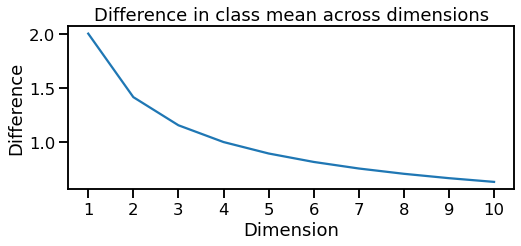

In [249]:
d = 10
mu1 = [1/np.sqrt(i) for i in range(1,d+1)]
mu2 = [-1/np.sqrt(i) for i in range(1,d+1)]
covariance = np.eye(d)

f, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(np.arange(1,d+1), np.asarray(mu1) - np.asarray(mu2))
ax.set_xticks(np.arange(1,d+1))
ax.set_xlabel('Dimension')
ax.set_ylabel('Difference')
ax.set_title('Difference in class mean across dimensions')
plt.show()

In [237]:
# Simulation
def simulate(n, d):
    mu1 = [1/np.sqrt(i) for i in range(1,d+1)]
    mu2 = [-1/np.sqrt(i) for i in range(1,d+1)]
    covariance = np.eye(d)

    X = np.vstack((
        np.random.multivariate_normal(mu1, covariance, n),
        np.random.multivariate_normal(mu2, covariance, n)
    ))
    
    return X, np.asarray([2]*n + [1]*n)

# Prediction
def gaussian_lik(x, mu):
    lik = np.sum((x - mu)**2, axis=1)
    return lik

class BayesClassifier:
    def __init__(self, method):
        self.method = method
        if method=='optimal':
            self.mu1 = np.asarray([1/np.sqrt(i) for i in range(1,d+1)])
            self.mu2 = np.asarray([-1/np.sqrt(i) for i in range(1,d+1)])            
    
    def fit(self, X, y):
        if self.method == 'naive':
            self.mu1 = np.mean(X[np.where(y==2)[0]], axis=0)
            self.mu2 = np.mean(X[np.where(y==1)[0]], axis=0)
        return self

    def predict(self, x):
        if self.method == 'optimal':
            proj = x @ self.mu1
            return (proj > 0).astype(int) + 1
        elif self.method == 'naive':
            lik1 = gaussian_lik(x, self.mu1)
            lik2 = gaussian_lik(x, self.mu2)
            return (lik1 < lik2).astype(int) + 1

With Gaussian models for the distributions of each class, we classify an observation as the class with the greatest likelihood. Given a mean $\mu$ and covariance $\Sigma$, the likelihood of an observation $x$ is 

$$P( x ; \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}}e^{-\frac{1}{2}(x - \mu)\Sigma ^{-1}(x - \mu)^T}$$

Because we know our covariance matrix to be the identity, this simplifies to

$$P( x ; \mu) = \frac{1}{\sqrt{(2\pi)^d}}e^{-\frac{1}{2}(x - \mu)^T(x - \mu)}$$

and we make the classification $y = argmax_{y \in \{0,1\}} P( x ; \mu_y)$. In the case of the Bayes optimal classifier (where we know all the parameters), the probability of error for a given dimension $d$ can analytically be written as

$$P_{error}(d) = \int^\infty_{\sqrt{\sum_{i=1}^{d}\frac{1}{i}}} \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}z^2} dz$$.

Clearly, in the limit as $d \rightarrow \infty$ this error $P_{error}(d) \rightarrow 0$ as the lower limit of integration diverges. This means, that we can perfectly discriminate the two classes in the limit **if we know the parameters**.

However, as in most real cases, we don't know the true parameters and need to estimate them. Here, we assume that only the means are unknown, a generous assumption. Thus, for each class we have a our max-liklihood estimate $\hat{\mu}_i$ of the mean and as Trunk showed, the analytical probability of error is

\begin{align}
    P_{error}(n,d) &= \int^{\infty}_{\theta(n,d)}\frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}z^2} dz,\\
    \theta(n,d) &= \frac{\sum_{i=1}^d (\frac{1}{i})}{\sqrt{(1 + \frac{1}{n})\sum_{i=1}^d (\frac{1}{i}) + \frac{d}{n}}}.
\end{align}

In this case, however, it is apparent that for a fixed $n$, $\theta(n,d) \rightarrow 0$ as $d \rightarrow \infty$. Thus, the probability of error integrates over half of the symmetric density and $P_{error}(n,d) \rightarrow \frac{1}{2}$ in the limit. Thus, if we do **not** know the parameters, increasing the number of dimensions catastrophically hurts our classification performance.

This distinction between the optimal and learned classifier is demonstrated empirically in the next plot and holds, as expected.

In [255]:
dim_range = [10,50,100,250,500,1000,2500,5000,10000]
optimal_accuracies = []
naive_accuracies = []
for d in dim_range:
    X_train, y_train = simulate(n=100, d=d)
    X_test, y_test = simulate(n=2000, d=d)
    
    bayes_optimal = BayesClassifier('optimal')
    bayes_naive = BayesClassifier('naive').fit(X_train, y_train)

    optimal_accuracies.append(np.mean(y_test == bayes_optimal.predict(X_test)))
    naive_accuracies.append(np.mean(y_test == bayes_naive.predict(X_test)))

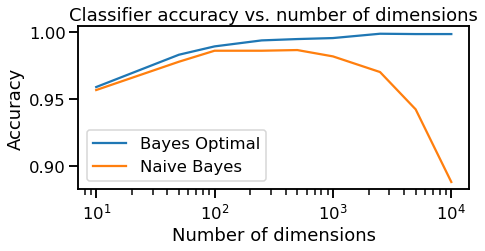

In [259]:
f, ax = plt.subplots(1,1,figsize=(7,3))
ax.plot(dim_range, optimal_accuracies, label='Bayes Optimal')
ax.plot(dim_range, naive_accuracies, label='Naive Bayes')
ax.set_xscale('log')
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('Accuracy')
ax.set_title('Classifier accuracy vs. number of dimensions')
ax.legend()
plt.show()

In summary, when learning a classifier from a finite amount of data, we do not want to arbitrarily utilize more features even if they are informative. Rather, as a designer of a practical implementation we wish to use those features which are most relevant.